<a href="https://colab.research.google.com/github/aflah02/Easy-Data-Augmentation-Implementation/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import pickle

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [34]:
def eda_SR(originalSentence, n):
  """
  Paper Methodology -> Randomly choose n words from the sentence that are not stop words. 
                       Replace each of these words with one of its synonyms chosen at random.
  originalSentence -> The sentence on which EDA is to be applied
  n -> The number of words to be chosen for random synonym replacement
  """
  stops = set(stopwords.words('english'))
  splitSentence = list(originalSentence.split(" "))
  splitSentenceCopy = splitSentence.copy()
  # Since We Make Changes to The Original Sentence List The Indexes Change and Hence an initial copy proves useful to get values
  ls_nonStopWordIndexes = []
  for i in range(len(splitSentence)):
    if splitSentence[i].lower() not in stops:
      ls_nonStopWordIndexes.append(i)
  if (n > len(ls_nonStopWordIndexes)):
    raise Exception("The number of replacements exceeds the number of non stop word words")
  for i in range(n):
    indexChosen = random.choice(ls_nonStopWordIndexes)
    ls_nonStopWordIndexes.remove(indexChosen)
    synonyms = []
    originalWord = splitSentenceCopy[indexChosen]
    for synset in wordnet.synsets(originalWord):
      for lemma in synset.lemmas():
        if lemma.name() != originalWord:
          synonyms.append(lemma.name())
    if (synonyms == []):
      continue
    splitSentence[indexChosen] = random.choice(synonyms).replace('_', ' ')
  return " ".join(splitSentence)

In [35]:
print(eda_SR("I love to play football", 2))

I fuck to play football game


In [31]:
def eda_RI(originalSentence, n):
  """
  Paper Methodology -> Find a random synonym of a random word in the sentence that is not a stop word. 
                       Insert that synonym into a random position in the sentence. Do this n times
  originalSentence -> The sentence on which EDA is to be applied
  n -> The number of times the process has to be repeated
  """
  stops = set(stopwords.words('english'))
  splitSentence = list(originalSentence.split(" "))
  splitSentenceCopy = splitSentence.copy() 
  # Since We Make Changes to The Original Sentence List The Indexes Change and Hence an initial copy proves useful to get values
  ls_nonStopWordIndexes = []
  for i in range(len(splitSentence)):
    if splitSentence[i].lower() not in stops:
      ls_nonStopWordIndexes.append(i)
  if (n > len(ls_nonStopWordIndexes)):
    raise Exception("The number of replacements exceeds the number of non stop word words")
  WordCount = len(splitSentence)
  for i in range(n):
    indexChosen = random.choice(ls_nonStopWordIndexes)
    ls_nonStopWordIndexes.remove(indexChosen)
    synonyms = []
    originalWord = splitSentenceCopy[indexChosen]
    for synset in wordnet.synsets(originalWord):
      for lemma in synset.lemmas():
        if lemma.name() != originalWord:
          synonyms.append(lemma.name())
    if (synonyms == []):
      continue
    splitSentence.insert(random.randint(0,WordCount-1), random.choice(synonyms).replace('_', ' '))
  return " ".join(splitSentence)

In [5]:
print(eda_RI("I love to play football", 2))

act I have sex love to play football


In [38]:
def eda_RS(originalSentence, n):
  """
  Paper Methodology -> Find a random synonym of a random word in the sentence that is not a stop word. 
                       Insert that synonym into a random position in the sentence. Do this n times
  originalSentence -> The sentence on which EDA is to be applied
  n -> The number of times the process has to be repeated
  """
  splitSentence = list(originalSentence.split(" "))
  WordCount = len(splitSentence)
  for i in range(n):
    firstIndex = random.randint(0,WordCount-1)
    secondIndex = random.randint(0,WordCount-1)
    while (secondIndex == firstIndex and WordCount != 1):
      secondIndex = random.randint(0,WordCount-1)
    splitSentence[firstIndex], splitSentence[secondIndex] = splitSentence[secondIndex], splitSentence[firstIndex]
  return " ".join(splitSentence)

In [7]:
print(eda_RS("I love to play football", 2))

football I to play love


In [40]:
def eda_RD(originalSentence, p):
  """
  Paper Methodology -> Randomly remove each word in the sentence with probability p.
  originalSentence -> The sentence on which EDA is to be applied
  p -> Probability of a Word Being Removed
  """
  og = originalSentence
  if (p == 1):
      raise Exception("Always an Empty String Will Be Returned") 
  if (p > 1 or p < 0):
    raise Exception("Improper Probability Value")
  splitSentence = list(originalSentence.split(" "))
  lsIndexesRemoved = []
  WordCount = len(splitSentence)
  for i in range(WordCount):
    randomDraw = random.random()
    if randomDraw <= p:
      lsIndexesRemoved.append(i)
  lsRetainingWords = []
  for i in range(len(splitSentence)):
    if i not in lsIndexesRemoved:
      lsRetainingWords.append(splitSentence[i])
  if (lsRetainingWords == []):
    return og
  return " ".join(lsRetainingWords)

In [9]:
print(eda_RD("I love to play football", 0.3))

I love to play football


### Building Dataset

In [10]:
!wget -q https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv
!wget -q https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv
!wget -q https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/dev.tsv

In [67]:
def buildTrainTestDatasets(doAug, AugTechs, alpha, NumberOfTrainingSamplesTouse, n_aug):
  df_train = pd.read_csv('train.tsv', delimiter = '\t', names = ['Sentence', 'Label'])
  # df_train['Split'] = 'Train'
  df_dev = pd.read_csv('dev.tsv', delimiter = '\t', names = ['Sentence', 'Label'])
  # df_dev['Split'] = 'Train' # Since The Original Dataset Does Not Use an Explicit Dev Set It's Considered To Be A Part of Test Set
  df_test = pd.read_csv('test.tsv', delimiter = '\t', names = ['Sentence', 'Label'])
  # df_test['Split'] = 'Test'
  df_train = pd.concat([df_train, df_dev])
  df_train = df_train.reset_index(drop=True)
  df_train = df_train.loc[:, ["Label", "Sentence"]]
  if (NumberOfTrainingSamplesTouse > len(df_train)):
    raise Exception("More Samples Asked For Than Present")
  df_train = df_train.iloc[:NumberOfTrainingSamplesTouse]
  if (doAug):
    if (AugTechs == None):
      AugTechs = ['SR', 'RI', 'RD', 'RS']
    ls_train_labels = df_train['Label'].to_list()
    ls_train_sentences = df_train['Sentence'].to_list()
    count = len(ls_train_sentences)
    for i in range(count):
      for iter in range(n_aug):
        ls_train_labels.append(ls_train_labels[i])
        techniqueChosen = random.choice(AugTechs)
        if (techniqueChosen == 'SR'):
          ls_train_sentences.append(eda_SR(ls_train_sentences[i], int(len(ls_train_sentences[i])*alpha)))
        elif (techniqueChosen == 'RI'):
          ls_train_sentences.append(eda_RI(ls_train_sentences[i], int(len(ls_train_sentences[i])*alpha)))
        elif (techniqueChosen == 'RS'):
          ls_train_sentences.append(eda_RS(ls_train_sentences[i], int(len(ls_train_sentences[i])*alpha)))
        elif (techniqueChosen == 'RD'):
          ls_train_sentences.append(eda_RD(ls_train_sentences[i], alpha))
    s1=pd.Series(ls_train_labels,name='Label')
    s2=pd.Series(ls_train_sentences,name='Sentence')
    df_train = pd.concat([s1,s2], axis=1, ignore_index=True)

  df_train.to_csv('datasettrain.csv', index=False)
  df_test = df_test.loc[:, ["Label", "Sentence"]]
  df_test.to_csv('datasettest.csv', index=False)

  column_names = ['Label','Sentence']
  batchsize = 1
  label = column_names[0]
  train_dataset = tf.data.experimental.make_csv_dataset(
      'datasettrain.csv',
      batchsize,
      column_names = column_names,
      label_name = label,
      num_epochs=1
  )

  column_names = ['Label','Sentence']
  batchsize = 1
  label = column_names[0]
  test_dataset = tf.data.experimental.make_csv_dataset(
      'datasettest.csv',
      batchsize,
      column_names = column_names,
      label_name = label,
      num_epochs=1
  )

  ls_train = []
  for example, label in train_dataset:
    ls_train.append([example['Sentence'][0],label[0]])

  nparrtrainsentences = np.array([])
  nparrtrainlabels = np.array([])
  for i in range(len(ls_train)):
    nparrtrainsentences = np.append(nparrtrainsentences, [ls_train[i][0].numpy()])
    nparrtrainlabels = np.append(nparrtrainlabels, [ls_train[i][1].numpy()])

  train_sentences = tf.convert_to_tensor(nparrtrainsentences)
  train_labels = tf.convert_to_tensor(nparrtrainlabels)

  train_dataset = tf.data.Dataset.from_tensors((train_sentences,train_labels))

  ls_test = []
  for example, label in test_dataset:
    ls_test.append([example['Sentence'][0],label[0]])

  nparrtestsentences = np.array([])
  nparrtestlabels = np.array([])
  for i in range(len(ls_test)):
    nparrtestsentences = np.append(nparrtestsentences, [ls_test[i][0].numpy()])
    nparrtestlabels = np.append(nparrtestlabels, [ls_test[i][1].numpy()])

  test_sentences = tf.convert_to_tensor(nparrtestsentences)
  test_labels = tf.convert_to_tensor(nparrtestlabels)
  test_dataset = tf.data.Dataset.from_tensors((test_sentences,test_labels))

  return (train_dataset, test_dataset)

In [68]:
train_aug, test_aug = buildTrainTestDatasets(True, None, 0.05, 500, 16)

In [69]:
train_non_aug, test_non_aug = buildTrainTestDatasets(False, None, 0, 500, 0)

In [61]:
for example, label in train_aug.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"high crimes carries almost no organic intrigue as a government marine legal mystery , and that 's because the movie serves up all of that , nearly subliminally , as the old hat province of male intrigue"
 b"the most detestable adjustment of a classic text since roland joff and demi Moore 's the scarlet letter"
 b'the film bewilder close to the chimps the same way goodall did , with a severe minded patience , regard and tenderness']

labels:  [0. 0. 1.]


## RNN Model

Paper Uses - 
The architecture used in this paper is as follows: input layer, bi-directional hidden layer with 64 LSTM cells, dropout layer with p=0.5, bi-directional layer of 32 LSTM cells, dropout layer with p=0.5, dense layer of 20 hidden units with ReLU activation, softmax output layer. We initialize this network with random normal weights and train against the categorical crossentropy loss function with the adam optimizer. We use early stopping with a patience of 3 epochs.

Reference for Encoder and some Helper Functions: [Tensorflow Text Classification by RNN Tutorial](https://www.tensorflow.org/text/tutorials/text_classification_rnn)



In [75]:
VOCAB_SIZE = 5000
encoder_aug = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder_aug.adapt(train_aug.map(lambda text, label: text))

vocab_aug = np.array(encoder_aug.get_vocabulary())

VOCAB_SIZE = 5000
encoder_nonaug = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder_nonaug.adapt(train_non_aug.map(lambda text, label: text))

vocab_nonaug = np.array(encoder_nonaug.get_vocabulary())


In [76]:
model_aug = tf.keras.Sequential([
    encoder_aug,
    tf.keras.layers.Embedding(len(encoder_aug.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1, kernel_initializer='normal', activation='softmax')
])
model_aug.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_nonaug = tf.keras.Sequential([
    encoder_nonaug,
    tf.keras.layers.Embedding(len(encoder_nonaug.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1, kernel_initializer='normal', activation='softmax')
])
model_nonaug.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [87]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

history_aug = model_aug.fit(	
      train_aug,
      epochs=3, 
      callbacks=callbacks,
      validation_data=test_aug,
      validation_steps=30
)

history_non_aug = model_nonaug.fit(	
      train_non_aug,
      epochs=3, 
      callbacks=callbacks,
      validation_data=test_non_aug,
      validation_steps=30
)

Epoch 1/3
1/1 [==============================] - 2s 2s/step - loss: 0.0000e+00 - accuracy: 0.5260 - val_loss: 0.0000e+00 - val_accuracy: 0.4992
Epoch 2/3
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 0.5260
Epoch 3/3
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 0.5260
Epoch 1/3
1/1 [==============================] - 7s 7s/step - loss: 0.0000e+00 - accuracy: 0.5260 - val_loss: 0.0000e+00 - val_accuracy: 0.4992
Epoch 2/3
1/1 [==============================] - 0s 117ms/step - loss: 0.0000e+00 - accuracy: 0.5260
Epoch 3/3
1/1 [==============================] - 0s 117ms/step - loss: 0.0000e+00 - accuracy: 0.5260


In [88]:
test_aug_loss, test_aug_acc = model_aug.evaluate(test_aug)

print('Test Augmented Loss:', test_aug_loss)
print('Test Augmented Accuracy:', test_aug_acc)

test_non_aug_loss, test_non_aug_acc = model_aug.evaluate(test_non_aug)

print('Test Non Augmented Loss:', test_non_aug_loss)
print('Test Non Augmented Accuracy:', test_non_aug_acc)

1/1 [==============================] - 0s 118ms/step - loss: 0.0000e+00 - accuracy: 0.4992
Test Augmented Loss: 0.0
Test Augmented Accuracy: 0.4991762638092041
1/1 [==============================] - 0s 112ms/step - loss: 0.0000e+00 - accuracy: 0.4992
Test Non Augmented Loss: 0.0
Test Non Augmented Accuracy: 0.4991762638092041


(0.0, 0.05500000000000001)

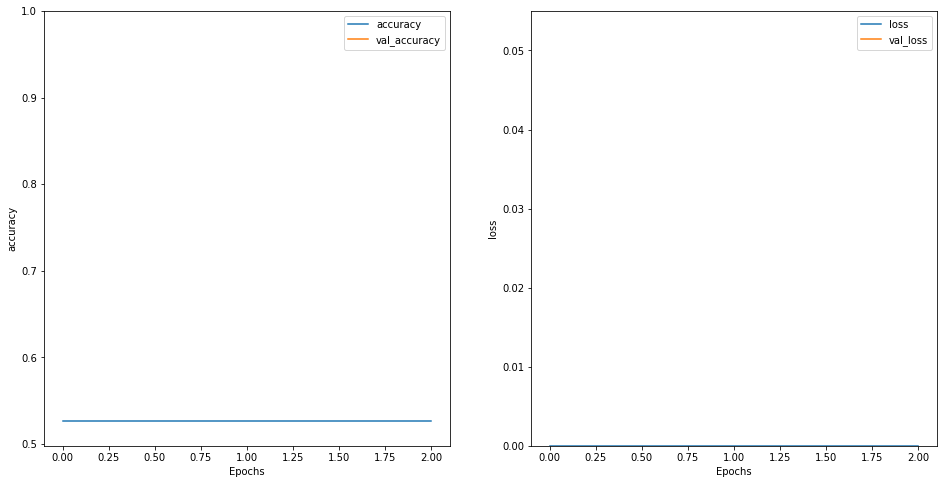

In [93]:
## Augmented Data Training
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_aug, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_aug, 'loss')
plt.ylim(0, None)

(0.0, 0.05500000000000001)

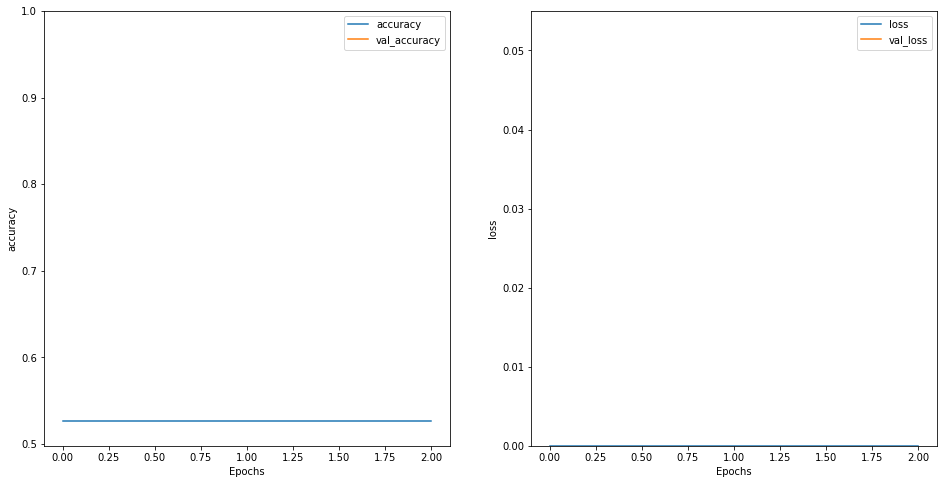

In [94]:
## Non Augmented Data Training
plt.figure(figsize=(16, 8))
plt.title("Non Augmented Data Training")
plt.subplot(1, 2, 1)
plot_graphs(history_non_aug, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_non_aug, 'loss')
plt.ylim(0, None)